In [220]:
"""!pip install wget
!pip install wandb
!pip install xtarfile"""

'!pip install wget\n!pip install wandb\n!pip install xtarfile'

### Configuration

In [221]:
START_TOKEN="0"
END_TOKEN="1"

In [222]:

import os
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import numpy as np
import keras
import tensorflow as tf
import xtarfile as tarfile
import csv
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      file_exists = exists('./dakshina_dataset_v1.0.tar')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
        print('download Complete')
      extract_exists = exists('./dakshina_dataset_v1.0/')   
      if(extract_exists==False): 
        print('Extracting..') 
        with tarfile.open('dakshina_dataset_v1.0.tar', 'r') as archive:
            archive.extractall()
        print('Complete')

      print('You are all set')

    def readData(self,dir,start_token="0",end_token="1"):
      # Vectorize the data.
      input_texts=list()
      target_texts=list()
      original_input_texts=list()
      original_target_texts=list()
      input_characters = set()
      target_characters = set()
      with open(dir, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
      
      for line in lines:
          ln = line.split("\t")
          if(len(ln)==3):
            target_text=ln[0].strip()  
            input_text=ln[1].strip()
            original_input_texts.append(input_text)
            original_target_texts.append(target_text)
            input_text+=start_token
            target_text = start_token + target_text + end_token
            input_texts.append(input_text)
            target_texts.append(target_text)
            for char in input_text:
              if char not in input_characters:
                input_characters.add(char)
            for char in target_text:
             if char not in target_characters:
               target_characters.add(char)
      input_characters = sorted(list(input_characters))
      target_characters = sorted(list(target_characters))
      return original_input_texts,original_target_texts,input_texts,target_texts,input_characters,target_characters


   

    #def encode_decode_characters(self,train_input, train_target, val_input=[], val_target=[],start_token="\t",end_token="\n"):
    def encode_decode_characters(self,train_input, train_target,start_token="0",end_token="1"):
        # Returns the encoding for characters to integer (as a dictionary) and decoding for integers to characters (as a list) for in
        BLANK_CHAR=' '
        # Encoding and decoding of input vocabulary
        input_char_enc = {}
        input_char_dec = []
        max_encoder_seq_length = 1
        tmplist=[]
        for i in train_input:
            tmplist.append(i)
        """for i in val_input:
            tmplist.append(i)"""
        for string in tmplist:
            max_encoder_seq_length = max(max_encoder_seq_length, len(string))
            for char in string:
                if char not in input_char_enc:
                    input_char_enc[char] = len(input_char_dec)
                    input_char_dec.append(char)
        """if BLANK_CHAR not in input_char_enc:
            input_char_enc[BLANK_CHAR] = len(input_char_dec)
            input_char_dec.append(BLANK_CHAR)
"""
        # Encoding and decoding of target vocabulary
        target_char_enc = {}
        target_char_dec = []
        target_char_enc[start_token] = len(target_char_dec)
        target_char_dec.append(start_token)
        max_decoder_seq_length = 1
        for string in train_target :#+ val_target:
            max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
            for char in string:
                if char not in target_char_enc:
                    target_char_enc[char] = len(target_char_dec)
                    target_char_dec.append(char)
        target_char_enc[end_token] = len(target_char_dec)
        target_char_dec.append(end_token)
        """if ' ' not in target_char_enc:
            target_char_enc[BLANK_CHAR] = len(target_char_dec)
            target_char_dec.append(BLANK_CHAR)"""

        """print("Number of training samples:", len(train_input))
        print("Number of validation samples:", len(val_input))
        print("Number of unique input tokens:", len(input_char_dec))
        print("Number of unique output tokens:", len(target_char_dec))
        print("Max sequence length for inputs:", max_encoder_seq_length)
        print("Max sequence length for outputs:", max_decoder_seq_length)"""

        return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length
    def preprocessing(self,input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,input_texts,target_texts,start_token="0",end_token="1"):
        encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length), dtype="float32")
        decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length), dtype="float32")
        decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_char_dec)), dtype="float32")
        for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
            for t, char in enumerate(input_text):
                encoder_input_data[i, t] =input_char_enc[char]
            #encoder_input_data[i, t + 1 :] = input_char_enc[start_token]

            for t, char in enumerate(target_text):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, ] = target_char_enc[char]
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    # and will not include the start character.
                    decoder_target_data[i, t - 1, target_char_enc[char]] = 1.0
            decoder_input_data[i, t + 1 :] = target_char_enc[end_token]
            decoder_target_data[i, t:, target_char_enc[end_token]] = 1.0
        return encoder_input_data,decoder_input_data,decoder_target_data


       
   

## Sequence to sequence RNN

In [223]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils.vis_utils import plot_model
class seqTOseq:
  def parameters(self,input_char_dec,target_char_dec,\
                 num_of_encoders=1,\
                 num_of_decoders=1,\
                 latent_dim=64,\
                 inp_emb_size=64,\
                 cell_type="lstm",\
                 cell_activation="tanh",\
                 optimizer="adam",\
                 dropout=0):
      self.num_encoder_tokens=len(input_char_dec)
      self.num_decoder_tokens=len(target_char_dec)
      self.latent_dim=latent_dim
      self.cell_type=cell_type
      self.optimizer=optimizer
      self.num_of_encoders=num_of_encoders
      self.num_of_decoders=num_of_decoders
      self.dropout=dropout
      self.inp_emb_size=inp_emb_size
      self.cell_activation=cell_activation
  def model(self):
      if(self.cell_type=="rnn"):
         cell=keras.layers.SimpleRNN
      if(self.cell_type=="lstm"):
        cell=keras.layers.LSTM     
      if(self.cell_type=="gru"):
         cell=keras.layers.GRU
      # Define an input sequence and process it.
      
      encoder_input = keras.layers.Input(shape=(None,), name="input_1")
      encoder_inp_emb = keras.layers.Embedding(self.num_encoder_tokens, self.inp_emb_size, name="embedding_1")(encoder_input)
      encoder =cell(self.latent_dim, return_state=True,\
                    return_sequences=True,\
                    activation=self.cell_activation,\
                    name="encoder_1",\
                    dropout=self.dropout)        
      
      encoder_outputs, *encoder_states = encoder(encoder_inp_emb)
      for i in range(1,self.num_of_encoders):
        encoder_outputs, *encoder_states = cell(self.latent_dim,\
                                       return_state=True,\
                                       return_sequences=True,\
                                       activation=self.cell_activation,\
                                       dropout=self.dropout,\
                                       name="encoder_"+str(i+1))(
                                                        encoder_outputs,initial_state=encoder_states
                                                 )
      # Set up the decoder, using `encoder_states` as initial state.
      decoder_inputs = keras.Input(shape=(None,), name="input_2")
      #input embedding 
      decoder_inp_emb = keras.layers.Embedding(self.num_decoder_tokens, self.inp_emb_size, name="embedding_2")(decoder_inputs)
      decoder=cell(self.latent_dim ,return_sequences=True,\
                   return_state=True,\
                   name="decoder_1",\
                   activation=self.cell_activation,\
                   dropout=self.dropout)
      decoder_outputs, *decode_states=decoder(decoder_inp_emb, initial_state=encoder_states)
      for i in range(1,self.num_of_decoders):
        decoder_outputs, *decode_states = cell(self.latent_dim,\
                                       return_state=True,\
                                       return_sequences=True,\
                                       activation=self.cell_activation,\
                                       dropout=self.dropout,\
                                       name="decoder_"+str(i+1))(
                                                        decoder_outputs,initial_state=encoder_states)
                                                 
      decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation="softmax")
      decoder_outputs = decoder_dense(decoder_outputs)
      # Define the model that will turn
      # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
      model = keras.Model([encoder_input, decoder_inputs], decoder_outputs)
      model.compile(optimizer=self.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
      return model
  def modelSummary(self,model):
      plot_model(model, to_file='encoder_model.png', show_shapes=True)
      f = plt.figure()
      f.set_figwidth(20)
      f.set_figheight(20)
      plt.imshow(mpimg.imread('encoder_model.png'))
      plt.axis('off')
 

  

### Read data from dataset

In [224]:
ds=Dataset()
ds.downloadDataSet()
language='hi'
train_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.train.tsv'
val_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.dev.tsv'
test_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.test.tsv'


You are all set


### Preprocessing data

In [225]:
train_original_input_texts,train_original_target_texts,train_ip_txt,train_op_txt,train_ip_chr,train_op_chr=ds.readData(train_dir)
val_original_input_texts,val_original_target_texts,val_ip_txt,val_op_txt,val_ip_chr,val_op_chr=ds.readData(val_dir)
test_original_input_texts,test_original_target_texts,test_ip_txt,test_op_txt,test_ip_chr,test_op_chr=ds.readData(test_dir)

In [226]:
"""input_char_enc, input_char_dec,\
 target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt, val_ip_txt, val_op_txt)"""

input_char_enc, input_char_dec,\
target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt)

##### Assigning training, validation and test encoder input, decoder input, decoder output

In [227]:

train_enc_input, train_dec_input, train_dec_target\
= ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,train_ip_txt, train_op_txt)



In [228]:
val_enc_input, val_dec_input, val_dec_target = \
ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,\
                 max_encoder_seq_length,max_decoder_seq_length,val_ip_txt, val_op_txt)


test_enc_input, test_dec_input, test_dec_target =\
 ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length\
                  ,test_ip_txt, test_op_txt)


In [229]:

def wordlevelAccurecy(model,target_char_enc,test_ip_txt,test_original_input_texts,test_original_target_texts):
    key_list = list(target_char_enc.keys())
    val_list = list(target_char_enc.values())
    predicted_data=model.predict([test_enc_input, test_dec_input ])
    targetpredicted=[]
    itr=0
    for data in predicted_data:
      wordip=test_ip_txt[itr]
      itr+=1
      wordop=""
      for i in data:

        index=np.argmax(i)
        position = val_list.index(index)
        wordop+=key_list[position]

      #wordop=wordop.replace('\t', '')
      #wordop=wordop.replace('\n', '')
      wordop=wordop.replace('0', '')
      wordop=wordop.replace('1', '')
      #wordop=wordop.replace(' ', '')
      targetpredicted.append(wordop)
      count=0
      countTot=0
    for i in range(len(targetpredicted)):
      countTot+=1
      if(test_original_target_texts[i]==targetpredicted[i]):
          count+=1
    print("word level accurecy: "+str (count/countTot))
    """for i in range(len(targetpredicted)):
    print(test_original_input_texts[i]+"   "+test_original_target_texts[i]+"  "+targetpredicted[i])"""



### Call the model

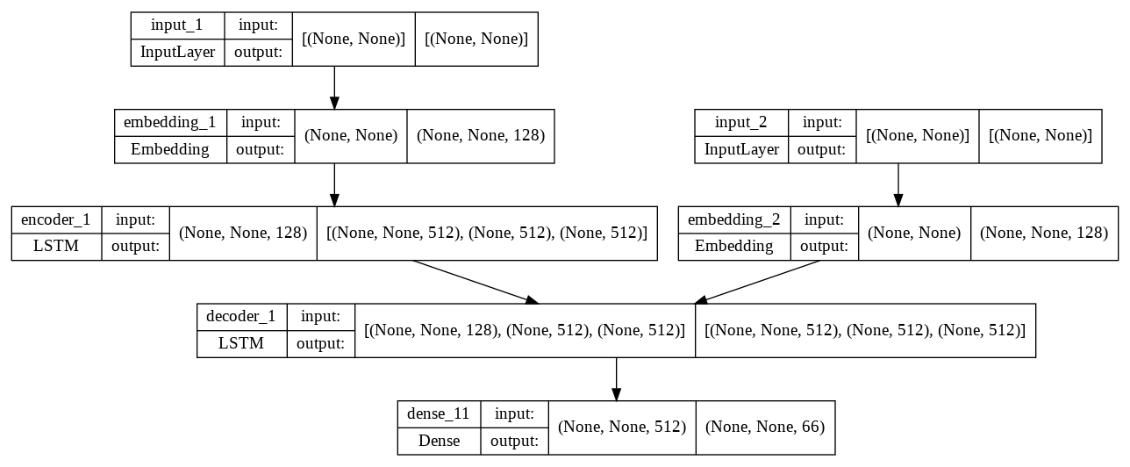

In [230]:
batch_size = 32  # Batch size for training.
epochs = 15  # Number of epochs to train for.
seq=seqTOseq()
seq.parameters(input_char_dec=input_char_dec,\
               target_char_dec=target_char_dec,\
               num_of_encoders=1,\
               num_of_decoders=1,
               latent_dim=512,\
               inp_emb_size=128,\
               cell_type="lstm",\
               cell_activation="tanh",\
               optimizer="adam",\
               dropout=.3)

model=seq.model()
seq.modelSummary(model)

In [231]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
       
    def on_epoch_end(self, epoch, logs={}):
        key_list = list(target_char_enc.keys())
        val_list = list(target_char_enc.values())
        predicted_data=self.model.predict([val_enc_input, val_dec_input ])
        targetpredicted=[]
        itr=0
        for data in predicted_data:
          wordip=test_ip_txt[itr]
          itr+=1
          wordop=""
          for i in data:
          
            index=np.argmax(i)
            position = val_list.index(index)
            wordop+=key_list[position]

          #wordop=wordop.replace('\t', '')
          #wordop=wordop.replace('\n', '')
          wordop=wordop.replace('0', '')
          wordop=wordop.replace('1', '')
          #wordop=wordop.replace(' ', '')
          targetpredicted.append(wordop)
          count=0
          countTot=0
        for i in range(len(targetpredicted)):
          countTot+=1
          if(val_original_target_texts[i]==targetpredicted[i]):
              count+=1
        print(" word level accurecy: "+str (count/countTot))
        

#### Train the model

In [232]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)
model.fit(
    [train_enc_input, train_dec_input],
    train_dec_target,
    batch_size=batch_size,
    epochs=epochs,
   validation_data=([val_enc_input, val_dec_input ] ,val_dec_target),
   callbacks=[earlystop,CustomCallback(model)]
)


Epoch 1/15
1382/1382 [==============================] - 19s 12ms/step - loss: 0.8070 - accuracy: 0.7835 - val_loss: 0.6150 - val_accuracy: 0.8244
Epoch 2/15
1382/1382 [==============================] - 15s 11ms/step - loss: 0.5080 - accuracy: 0.8491 - val_loss: 0.3424 - val_accuracy: 0.8944
Epoch 3/15
1382/1382 [==============================] - 15s 11ms/step - loss: 0.2608 - accuracy: 0.9188 - val_loss: 0.2018 - val_accuracy: 0.9374
Epoch 4/15
1382/1382 [==============================] - 15s 11ms/step - loss: 0.1582 - accuracy: 0.9504 - val_loss: 0.1655 - val_accuracy: 0.9484
Epoch 5/15
1382/1382 [==============================] - 15s 11ms/step - loss: 0.1142 - accuracy: 0.9641 - val_loss: 0.1566 - val_accuracy: 0.9520
Epoch 6/15
1382/1382 [==============================] - 15s 11ms/step - loss: 0.0879 - accuracy: 0.9722 - val_loss: 0.1539 - val_accuracy: 0.9535
Epoch 7/15
1382/1382 [==============================] - 15s 11ms/step - loss: 0.0705 - accuracy: 0.9777 - val_loss: 0.1558 -

In [233]:
wordlevelAccurecy(model,target_char_enc,test_ip_txt,test_original_input_texts,test_original_target_texts)

word level accurecy: 0.346512661039538


In [ ]:
model.save("s2s")

In [ ]:
model = keras.models.load_model("s2s")
